<a href="https://colab.research.google.com/github/masterschool-content/retail_demand_forecast/blob/main/notebooks/Classical_forecasting_with_DARTS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install DARTS

In [1]:
!pip install darts

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.0/52.0 kB 3.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.8/165.8 kB 7.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 934.2/934.2 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 35.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 28.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.1/319.1 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.6/275.6 kB 15.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 278.2/278.2 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 926.4/926.4 kB 32.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 1.9 MB/s eta 0:00:0

# Import all libraries we will need

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from darts import TimeSeries

# Connect to Goole Drive

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Read the files with pandas

In [4]:
# Load the CSV files into pandas DataFrames
df_stores = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/stores.csv')
df_items = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/items.csv')
df_transactions = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/transactions.csv')
df_oil = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/oil.csv')
df_holidays_events = pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/holidays_events.csv')

In [5]:
# Let's filter the data for one store and one item to keep it simple
store_ids = [1]
item_ids = [96995]
#Select data before April'14
max_date = '2014-04-01'


# Initialize an empty list to hold filtered chunks
filtered_chunks = []

# Define the chunk size (number of rows per chunk)
chunk_size = 10 ** 6  # Adjust based on your system's memory capacity

# Read the CSV file in chunks
for chunk in pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/train.csv', chunksize=chunk_size):
    # Filter the chunk for the desired store IDs
    chunk_filtered = chunk[(chunk['store_nbr'].isin(store_ids)) & (chunk['item_nbr'].isin(item_ids)) & (chunk['date']<max_date)]
    # Append the filtered chunk to the list
    filtered_chunks.append(chunk_filtered)
    # Optional: Delete the chunk to free up memory
    del chunk

# Concatenate all filtered chunks into a single DataFrame
df_filtered = pd.concat(filtered_chunks, ignore_index=True)

# Clean up to free memory
del filtered_chunks

<ipython-input-5-bd7586eec8b9>:15: DtypeWarning: Columns (5) have mixed types. Specify dtype option on import or set low_memory=False.
  for chunk in pd.read_csv('/content/drive/MyDrive/retail_kaggle_data/train.csv', chunksize=chunk_size):


# Prepare data

<Axes: xlabel='date'>

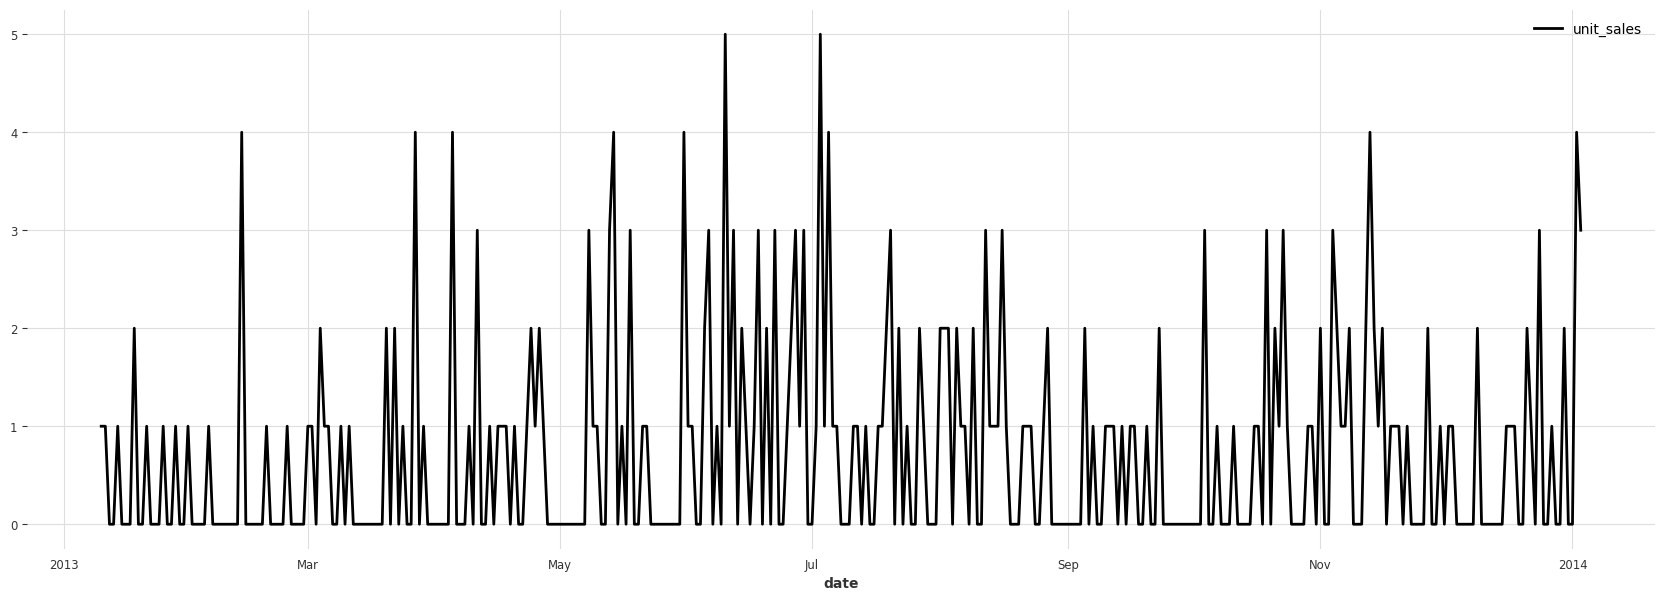

In [6]:
df_filtered['date'] = pd.to_datetime(df_filtered['date'])
# Group by date and aggregate sales for each day
df_filtered = df_filtered.groupby('date').sum()['unit_sales'].reset_index()

# Fill missing dates with zero sales (since some dates may have no sales)
df_filtered.set_index('date', inplace=True)
df_filtered = df_filtered.asfreq('D').fillna(0)

# Convert to a Darts TimeSeries object
series = TimeSeries.from_dataframe(df_filtered, value_cols='unit_sales')

# Visualize the filtered sales data
plt.figure(figsize=(21, 7))  # Adjust the figure size (width, height)
series.plot()

# Split data in training and test

In [7]:
# Split the data (80% training, 20% testing)
train, test = series.split_after(0.8)

# ARIMA

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


<Axes: xlabel='date'>

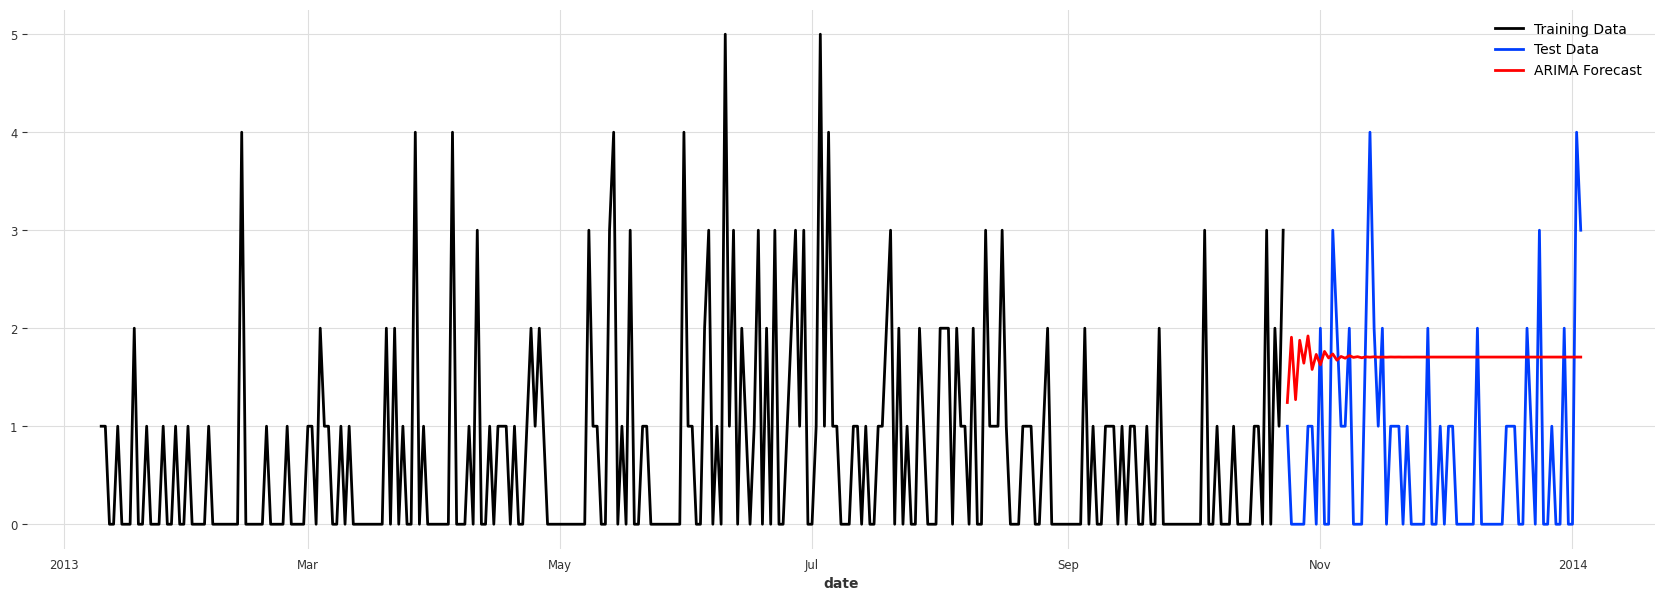

In [8]:
from darts.models import ARIMA

# Initialize ARIMA model with (p, d, q) parameters
arima_model = ARIMA(p=5, d=1, q=0)  # ARIMA(p, d, q)

# Fit the ARIMA model on the training data
arima_model.fit(train)

# Forecast the next values (the same length as the test set)
arima_forecast = arima_model.predict(len(test))

# Plot ARIMA forecast vs actual data
plt.figure(figsize=(21, 7))  # Adjust the figure size (width, height)
train.plot(label='Training Data')
test.plot(label='Test Data')
arima_forecast.plot(label='ARIMA Forecast', color='red')

# SARIMA

<Axes: xlabel='date'>

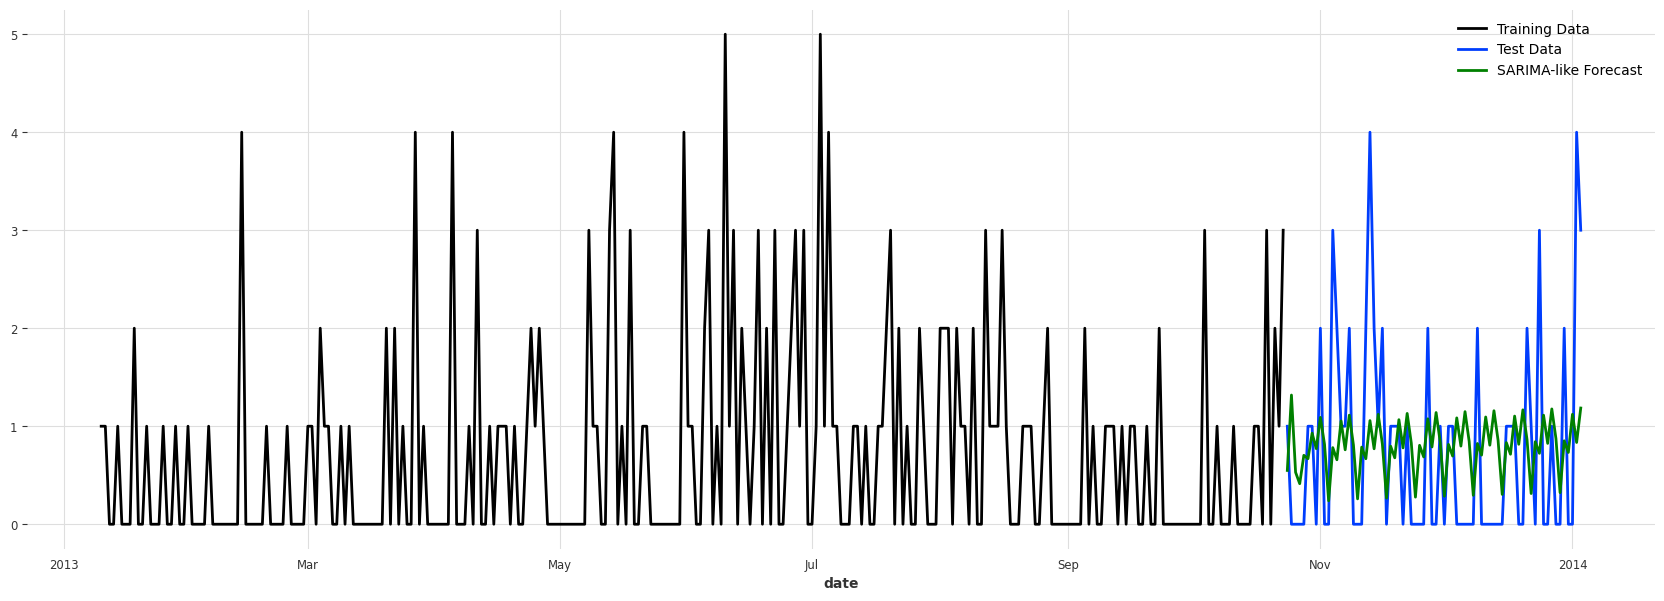

In [9]:
from darts.models import ARIMA

# Initialize ARIMA model with both (p, d, q) and (P, D, Q, m) parameters
# (P, D, Q, m) = (1, 1, 1, 7) for seasonal components (e.g., weekly seasonality)
sarima_like_model = ARIMA(p=5, d=1, q=1, seasonal_order=(1, 1, 1, 7))

# Fit the ARIMA model with seasonality on the training data
sarima_like_model.fit(train)

# Forecast the next values (the same length as the test set)
sarima_forecast = sarima_like_model.predict(len(test))

# Plot SARIMA-like forecast vs actual data
plt.figure(figsize=(21, 7))  # Adjust the figure size (width, height)
train.plot(label='Training Data')
test.plot(label='Test Data')
sarima_forecast.plot(label='SARIMA-like Forecast', color='green')
